## Environment Setting and Data Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import spacy
import gensim
import time

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

20

In [4]:
# !pip install pandarallel

In [5]:
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [6]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [10]:
%%time
import pickle
df_filtered = pd.read_pickle('df_topic_modeling.pkl')
df_filtered.head(1)

CPU times: total: 6.97 s
Wall time: 17 s


,date,domain,clean_text,clean_token,sentiment_robert,sentiment_ner_with_product,ktrain_topic
0,2021-03-18,en.people.cn,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,positive,E...,automotive


In [11]:
df_filtered.shape

(135297, 7)

## LDA with Hyperparameter Tuning with Sample

In [9]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [10]:
df_sample = df_filtered.sample(frac=0.05, random_state=1)
df_sample.shape

(6765, 6)

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


        
sample_list = df_sample['clean_text'].tolist()        
sample_tokens = list(sent_to_words(sample_list))

In [12]:
bigram = gensim.models.Phrases(sample_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[sample_tokens], threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
sample_tokens_nostops = remove_stopwords(sample_tokens)

# Create n-grams
sample_words_trigrams = make_trigrams(sample_tokens_nostops)

# Combine tokens and n-grams (this time we only do trigrams)
sample_tokens_combined = sample_words_trigrams 

# Lemmatize text keeping only noun, adj, vb, adv
sample_lemmatized = lemmatization(sample_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
sample_dictionary = corpora.Dictionary(sample_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
sample_doc_term_matrix = [sample_dictionary.doc2bow(doc) for doc in sample_lemmatized]

In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, data_lemmatized):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=num_processors-1)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
topics_range = [20, 25, 30, 140, 150]

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(sample_doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               sample_doc_term_matrix] # simply use the whole matrix

# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=sample_dictionary, 
                                              k=k, a=a, b=b, data_lemmatized=sample_lemmatized)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
                # print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
sample_lda_tuning = pd.DataFrame(model_results)
sample_lda_tuning

LDA will execute 150 iterations
Completed model based on 20 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 20: 0hour:57min:32sec
Completed model based on 25 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 25: 1hour:13min:36sec
Completed model based on 30 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 30: 1hour:26min:17sec
Completed model based on 140 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate for topic 140: 3hour:28min:3sec
Completed model based on 150 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 150: 4hour:44min:23sec


,Topics,Alpha,Beta,Coherence
0,20,0.01,0.01,0.362910
1,20,0.01,0.31,0.410539
2,20,0.01,0.61,0.484452
3,20,0.01,0.91,0.469680
4,20,0.01,symmetric,0.354605
...,...,...,...,...
145,150,asymmetric,0.01,0.368227
146,150,asymmetric,0.31,0.466991
147,150,asymmetric,0.61,0.466836
148,150,asymmetric,0.91,0.447392


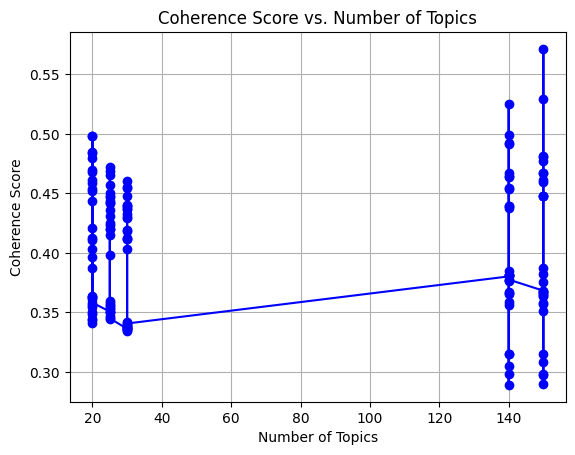

In [19]:
# Plot coherence scores
plt.plot(sample_lda_tuning['Topics'].to_numpy(), sample_lda_tuning['Coherence'].to_numpy(), 'b-o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [20]:
max_row_index = sample_lda_tuning['Coherence'].idxmax()
max_row = sample_lda_tuning.loc[max_row_index]
max_row

Topics            150
Alpha            0.31
Beta             0.91
Coherence    0.571352
Name: 128, dtype: object

In [20]:
best_sample_lda_model = LdaMulticore(corpus=sample_doc_term_matrix,
                   id2word=sample_dictionary,
                   num_topics=150,
                   random_state=100,                  
                   passes=10,
                   alpha=0.31,
                   eta=0.91,
                   workers=num_processors-1)


In [21]:

topics = best_sample_lda_model.print_topics(num_topics=150, num_words=10)
topic_data = []

for topic in topics:
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].strip().replace('"', '') for word in words]
    topic_data.append(topic_words)

df_topics = pd.DataFrame(topic_data, columns=[f"Topic{i}" for i in range(10)])
df_topics.insert(0, "Topic", range(150))


In [44]:
df_topics

,Topic,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0,ҳлиө,wind,ләел_мқј,ҳл_ҙм,җлҹ,ҳлқҳ,ҳкің,лҙј,ліҙлҙј,нҷ
1,1,arena_analytic,training_sample,distinguished_industry,use,smother,market,zac,deep_convolutional_neural_network,naturally_stop,connect_women
2,2,medical_ai_data_analysis,first_picture,google_parent_company_alphabet,steamtown,performances_take,wednesday_alphabet,widespread_job_cut,knowing_machine,tech_sector_alphabet_cut,engine_publicly
3,3,pmsport,match_feb,wickets_root,ing_car,market,use,ai,company,say,technology
4,4,transaction_review,uses_advance,use,billing_detail,bonifazidenver_co,cofive,ai,datum,say,technology_digit
...,...,...,...,...,...,...,...,...,...,...,...
145,145,wvlt_newsfirst,wayanythe,teamcareerswvlt_paid,alert_weatherfirst_alert_weather,alert_live,dividesupport_local,calendarcontact_usmeet,solutionsmedal,cookingeye,possiblelet_get
146,146,technology_review,alphafold,fox_business,protein,rogd,proteins_found,refinitiv_lipper,million_structure,statement_mutual,market_data_provide
147,147,market,report,santo_cjmorne,invest,call_trading_calls_trade,markets_data_exclusive_trade,thomson_reutersdetail,equity_analysis_actionable_investment,sip_balancerdelay,trackersip_performance
148,148,new_exhibition,world_renowned,rapture,press_preview,content_markete,market,lisbon,complainour_brandsprivacy,bicycle,franca


## Ktrain with Found Optimal n_topics

#### Setting

In [25]:
import tensorflow as tf

In [26]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [27]:
#!pip install ktrain

In [28]:
import ktrain
from ktrain import text as txt

print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.37.0


In [30]:
texts = df_filtered['clean_token'].tolist()

In [66]:
def print_n_topics(model, n_words):
    feature_names = model.vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.model.components_):
        top_features_ind = topic.argsort()[-n_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx} | {' '.join(top_features)}")


In [76]:
def topics_to_df(model, n_words):

    feature_names = model.vectorizer.get_feature_names_out()


    df = pd.DataFrame(columns=[f"Keyword {i+1}" for i in range(n_words)])

    for topic_idx, topic in enumerate(model.model.components_):
        top_features_ind = topic.argsort()[-n_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]

        df.loc[f"Topic {topic_idx+1}"] = top_features

    return df



#### 5 topics

In [27]:
tm_5 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=5, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [28]:
tm_5.print_topics()

topic 0 | share stock news investment fund dollar best investor trade price
topic 1 | solution customer learning business platform service machine help model use
topic 2 | chatgpt said like google human use people tool user time
topic 3 | market report global artificial analysis growth industry research forecast key
topic 4 | republic said news state say people day year india world


#### 20 topics

In [31]:
tm_20 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=20, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [68]:
print_n_topics(tm_20, 5)

Topic 0 | security news privacy military policy
Topic 1 | model algorithm used use information
Topic 2 | google customer content marketing product
Topic 3 | science research computer university learning
Topic 4 | image video game open best
Topic 5 | energy oil europe gas solution
Topic 6 | human like chatgpt student way
Topic 7 | chatgpt microsoft openai said google
Topic 8 | india news education live indian
Topic 9 | star look film say day
Topic 10 | patient health medical healthcare drug
Topic 11 | best car insurance credit vehicle
Topic 12 | market report global analysis growth
Topic 13 | stock share dollar fund trade
Topic 14 | machine learning chip service conversational
Topic 15 | said china year state say
Topic 16 | solution platform customer cloud edge
Topic 17 | business industry help digital organization
Topic 18 | republic kingdom people philip state
Topic 19 | said people say like law


In [79]:
topics_to_df(tm_20, 10)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1,security,news,privacy,military,policy,cyber,cybersecurity,threat,comment,attack
Topic 2,model,algorithm,used,use,information,using,image,process,time,result
Topic 3,google,customer,content,marketing,product,brand,medium,business,search,experience
Topic 4,science,research,computer,university,learning,scientist,researcher,course,machine,project
Topic 5,image,video,game,open,best,feature,app,apple,window,like
Topic 6,energy,oil,europe,gas,solution,european,market,patent,launch,service
Topic 7,human,like,chatgpt,student,way,work,make,time,people,language
Topic 8,chatgpt,microsoft,openai,said,google,user,chatbot,model,search,generative
Topic 9,india,news,education,live,indian,day,world,video,said,watch
Topic 10,star,look,film,say,day,reveals,year,black,fan,time


In [93]:
topic_probabilities = tm_20.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_filtered['ktrain_20_topic_id'] = topic_ids

In [94]:
# cyber security
df_filtered[df_filtered.ktrain_20_topic_id == 0].shape

(2810, 11)

In [95]:
# healthcare
df_filtered[df_filtered.ktrain_20_topic_id == 11].shape

(1755, 11)

In [96]:
# fintech
df_filtered[df_filtered.ktrain_20_topic_id == 14].shape

(103, 11)

#### 30 topics

In [33]:
tm_30 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=30, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [67]:
print_n_topics(tm_30, 5)

Topic 0 | security news cybersecurity cyber threat
Topic 1 | model algorithm used language training
Topic 2 | image photo art artist create
Topic 3 | science research university course project
Topic 4 | game music world voice time
Topic 5 | die solution philip und service
Topic 6 | energy vehicle robot car autonomous
Topic 7 | news content comment medium email
Topic 8 | said state city say country
Topic 9 | star reveals look daughter say
Topic 10 | patient health healthcare medical care
Topic 11 | china year financial investment bank
Topic 12 | market report analysis global growth
Topic 13 | share stock dollar traded trade
Topic 14 | machine learning service conversational amazon
Topic 15 | researcher study said research child
Topic 16 | platform solution service customer cloud
Topic 17 | risk bias use organization development
Topic 18 | republic best insurance credit forbes
Topic 19 | human like say people thing
Topic 20 | india indian share video news
Topic 21 | edge chip nvidia devi

In [89]:
topics_to_df(tm_30, 10)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1,security,news,cybersecurity,cyber,threat,attack,digital,network,policy,privacy
Topic 2,model,algorithm,used,language,training,use,using,human,process,network
Topic 3,image,photo,art,artist,create,tool,like,video,work,app
Topic 4,science,research,university,course,project,scientist,program,student,institute,engineering
Topic 5,game,music,world,voice,time,year,day,player,video,like
Topic 6,die,solution,philip,und,service,crypto,europe,european,launch,business
Topic 7,energy,vehicle,robot,car,autonomous,driver,driving,gas,oil,tesla
Topic 8,news,content,comment,medium,email,post,facebook,social,open,user
Topic 9,said,state,city,say,country,year,police,president,national,military
Topic 10,star,reveals,look,daughter,say,black,share,husband,year,wife


In [80]:
topic_probabilities = tm_30.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_filtered['ktrain_30_topic_id'] = topic_ids

In [98]:
# cyber security
df_filtered[df_filtered.ktrain_30_topic_id == 0].shape

(1608, 11)

In [99]:
# human
df_filtered[df_filtered.ktrain_30_topic_id == 20].shape

(1723, 11)

In [100]:
# automotive
df_filtered[df_filtered.ktrain_30_topic_id == 7].shape

(4452, 11)

In [101]:
# healthcare
df_filtered[df_filtered.ktrain_30_topic_id == 11].shape

(3008, 11)

In [102]:
# studio_art
df_filtered[df_filtered.ktrain_30_topic_id == 3].shape

(3200, 11)

In [103]:
# education
df_filtered[(df_filtered.ktrain_30_topic_id == 23)].shape

(5217, 11)

In [104]:
# techonology
df_filtered[df_filtered.ktrain_30_topic_id == 22].shape

(1940, 11)

#### 40 topics

In [35]:
tm_40 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=40, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [105]:
print_n_topics(tm_40, 5)

Topic 0 | security military cyber cybersecurity threat
Topic 1 | model language use process training
Topic 2 | best insurance credit card forbes
Topic 3 | science student education university course
Topic 4 | image art photo artist like
Topic 5 | crypto philip service citizen investment
Topic 6 | year million billion investment startup
Topic 7 | user content news medium comment
Topic 8 | india indian news live day
Topic 9 | star reveals look daughter say
Topic 10 | healthcare medical drug discovery medicine
Topic 11 | algorithm network model using result
Topic 12 | market report analysis global growth
Topic 13 | dollar traded trade btc distribution
Topic 14 | machine learning service amazon deep
Topic 15 | researcher research university scientist study
Topic 16 | platform solution service customer enterprise
Topic 17 | window open child click county
Topic 18 | car vehicle driver driving tesla
Topic 19 | said bias risk use tool
Topic 20 | news cloud ibm retail telecom
Topic 21 | edge de

In [106]:
topics_to_df(tm_40, 10)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1,security,military,cyber,cybersecurity,threat,defense,attack,satellite,force,air
Topic 2,model,language,use,process,training,tool,information,task,example,used
Topic 3,best,insurance,credit,card,forbes,paid,program,loan,real,travel
Topic 4,science,student,education,university,course,skill,school,research,program,starfilled
Topic 5,image,art,photo,artist,like,tool,create,work,people,said
Topic 6,crypto,philip,service,citizen,investment,care,product,cryptocurrency,contact,support
Topic 7,year,million,billion,investment,startup,tech,investor,market,said,venture
Topic 8,user,content,news,medium,comment,email,social,facebook,musk,twitter
Topic 9,india,indian,news,live,day,watch,video,said,world,minister
Topic 10,star,reveals,look,daughter,say,share,baby,black,husband,wife


In [141]:
topics_to_df(tm_40, 5).iloc[[2, 36, 3, 4, 39]]

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5
Topic 3,best,insurance,credit,card,forbes
Topic 37,patient,health,cancer,care,hospital
Topic 4,science,student,education,university,course
Topic 5,image,art,photo,artist,like
Topic 40,chip,nvidia,computing,hardware,intel


In [145]:
concernd_visualize = topics_to_df(tm_40, 10).iloc[[0, 19]]
concernd_visualize

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1,security,military,cyber,cybersecurity,threat,defense,attack,satellite,force,air
Topic 20,said,bias,risk,use,tool,ethical,people,government,right,regulation


In [146]:
concernd_visualize.loc['Topic 20', 'Keyword 1'] = concernd_visualize.loc['Topic 20', 'Keyword 9']
concernd_visualize.loc['Topic 20', 'Keyword 4'] = concernd_visualize.loc['Topic 20', 'Keyword 10']
concernd_visualize.loc['Topic 20', 'Keyword 5'] = concernd_visualize.loc['Topic 20', 'Keyword 6']
concernd_visualize.iloc[:, :5]

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5
Topic 1,security,military,cyber,cybersecurity,threat
Topic 20,right,bias,risk,regulation,ethical


In [107]:
topic_probabilities = tm_40.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_filtered['ktrain_40_topic_id'] = topic_ids

In [108]:
# cyber security
df_filtered[df_filtered.ktrain_40_topic_id == 0].shape

(2155, 12)

In [119]:
# concerns
df_filtered[df_filtered.ktrain_40_topic_id == 19].shape

(5173, 12)

In [126]:
# finance + crypto + trade
df_filtered[(df_filtered.ktrain_40_topic_id == 2) | (df_filtered.ktrain_40_topic_id == 5) | (df_filtered.ktrain_40_topic_id == 13)].shape

(3613, 12)

In [121]:
# education
df_filtered[df_filtered.ktrain_40_topic_id == 3].shape

(2733, 12)

In [137]:
# studio_art
df_filtered[df_filtered.ktrain_40_topic_id == 4].shape

(3345, 12)

In [128]:
# healthcare
df_filtered[(df_filtered.ktrain_40_topic_id == 10) | (df_filtered.ktrain_40_topic_id == 36)].shape

(7049, 12)

In [122]:
# automotive
df_filtered[df_filtered.ktrain_40_topic_id == 18].shape

(1199, 12)

In [123]:
# related hardware
df_filtered[df_filtered.ktrain_40_topic_id == 39].shape

(2489, 12)

In [129]:
# application
df_filtered[(df_filtered.ktrain_40_topic_id == 21) | (df_filtered.ktrain_40_topic_id == 31)].shape

(6806, 12)

#### 150 topics

In [31]:
tm_150 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=150, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [32]:
tm_150.print_topics()

topic 0 | oil gas price market say stock min inflation rate bank
topic 1 | patient health healthcare medical care hospital clinical imaging disease treatment
topic 2 | google said tech year giant alphabet according week pichai ceo
topic 3 | center contact agent var customer node research request communication field
topic 4 | research project engineering community team said work join access building
topic 5 | updated hour minute prnewsfoto skip news today announced logo weather
topic 6 | cancer breast lunit study screening tissue patient lung clinical image
topic 7 | light eye noise radio station motion zoom mode cool room
topic 8 | camera sensor design module application power product embedded control kit
topic 9 | scott daniel club allen hill suicide thomas colorado delta brown
topic 10 | city traffic transportation road urban location transport map forest download
topic 11 | canada canadian toronto ontario assange donor say montreal urine bell
topic 12 | artificial market report anal

#### Label useful result

In [ ]:
import numpy as np

topic_probabilities = tm_20.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_filtered['ktrain_20_topic_id'] = topic_ids

In [130]:
topic_mapping = {0: "cybersecurity",  
                 19: "concerns", 
                 2: "finance", 
                 5: "finance", 
                 13: "finance", 
                 3: "education", 
                 4: "studio_art",
                 10: "healthcare", 
                 36: "healthcare",
                 18: "automotive",
                 39: "related_hardware",
                 21: "applications",
                 31: "applications" }

df_filtered['ktrain_topic'] = df_filtered['ktrain_40_topic_id'].map(topic_mapping).fillna("Others")

In [132]:
df_filtered.head()

,date,domain,clean_text,clean_token,sentiment_robert,sentiment_ner_with_product,ktrain_topic,clean_text_without_stopwords,bert_auto_topic_id,ktrain_30_topic_id,ktrain_20_topic_id,ktrain_40_topic_id
0,2021-03-18,en.people.cn,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,positive,E...,automotive,Thanks application artificial intelligence ( A...,12,8,15,18
1,2021-03-10,www.homeoffice.consumerelectronicsnet.com,BOSTON–(BUSINESS WIRE)–Strategy Analytics in a...,business wire analytics newly published report...,positive,...,applications,BOSTON– ( BUSINESS WIRE ) –Strategy Analytics ...,-1,21,16,21
2,2020-10-20,www.itbusinessnet.com,"TOKYO, Oct 20, 2020 – (ACN Newswire) – Olympus...",tokyo oct acn newswire olympus corporation too...,neutral,...,healthcare,"TOKYO , Oct 20 , 2020 – ( ACN Newswire ) – Oly...",2,10,10,36
3,2021-02-25,www.peripherals.consumerelectronicsnet.com,"MulticoreWare Inc., joins the CEVAnet™ Partner...",multicoreware join partner program comprehensi...,positive,Entity La...,applications,"MulticoreWare Inc. , joins CEVAnet™ Partner Pr...",-1,16,16,21
4,2020-06-23,www.productivityapps.itbusinessnet.com,"), provider of a next generation test automati...",provider next generation test automation platf...,positive,...,Others,") , provider next generation test automation p...",3,16,1,1


In [134]:
df_filtered.to_pickle('df_topic.pkl')

## BERTopic

#### Setting

In [12]:
# !pip install bertopic

In [13]:
# !pip install --upgrade transformers bertopic accelerate

In [14]:
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer

e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython'

In [15]:
def remove_stopwords(sentence):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in tokens if not word in stop_words]
    return " ".join(filtered_sentence)

In [16]:
%%time
df_filtered['clean_text_without_stopwords'] = df_filtered['clean_text'].parallel_apply(remove_stopwords)

CPU times: total: 4.67 s
Wall time: 1min 10s


#### On Sample

In [ ]:
# first try on sample
df_sample = df_filtered.sample(n=10000)
sample_documents = df_sample['clean_text_without_stopwords'].tolist()  

In [ ]:
# Create a BERTopic model
sample_topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=50)

In [ ]:
sample_topics, sample_probabilities = sample_topic_model_auto.fit_transform(sample_documents)

In [ ]:
sample_topic_keywords = sample_topic_model_auto.get_topic_info()

In [ ]:
for topic in sample_topic_keywords['Topic'].unique():
    sample_keywords = sample_topic_model_auto.get_topic(topic)
    sample_keywords, _ = zip(*sample_keywords[:5])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {sample_keywords}")

#### On Full Dataset

##### Auto n_topics

In [19]:
# Create a BERTopic model
topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=200)

In [21]:
%%time
topics_auto, probabilities_auto = topic_model_auto.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

CPU times: total: 4h 38min 22s
Wall time: 2h 48min 3s


In [22]:
topic_keywords_auto = topic_model_auto.get_topic_info()

In [42]:
for topic in topic_keywords_auto['Topic'].unique():
    keywords_20 = topic_model_auto.get_topic(topic)
    keywords_20, _ = zip(*keywords_20[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} | {' '.join(keywords_20)}")  # join keywords with space

Topic -1 | ai the new data said technology it also intelligence company
Topic 0 | market report global analysis growth intelligence artificial forecast industry players
Topic 1 | ai data the new use it also technology time human
Topic 2 | health patients healthcare medical cancer patient clinical the ai care
Topic 3 | ai data the company said technology new business also million
Topic 4 | market report global analysis growth intelligence artificial forecast key players
Topic 5 | ai data results search platform no market the solutions typing
Topic 6 | the new star to day says said india video watch
Topic 7 | skip ai weather updated fund platform data 2022 technology distribution
Topic 8 | google chatgpt search bard bing microsoft ai openai chatbot new
Topic 9 | china chinese baidu ai said ernie the us technology chatgpt
Topic 10 | market healthcare intelligence artificial report analysis global medical growth research
Topic 11 | the space earth new researchers learning data machine scie

In [39]:
bertopic_result = topic_model_auto.get_document_info(df_filtered.clean_text_without_stopwords)
bertopic_result['Name'].value_counts()

-1_ai_the_new_data                                            74090
0_market_report_global_analysis                                9397
1_ai_data_the_new                                              6752
2_health_patients_healthcare_medical                           6657
3_ai_data_the_company                                          4321
4_market_report_global_analysis                                4164
5_ai_data_results_search                                       3648
6_the_new_star_to                                              2962
7_skip_ai_weather_updated                                      1775
8_google_chatgpt_search_bard                                   1396
9_china_chinese_baidu_ai                                       1389
10_market_healthcare_intelligence_artificial                   1300
11_the_space_earth_new                                         1183
12_tesla_driving_car_vehicle                                    902
13_republic_wfmz_comments_posts                 

In [43]:
similar_topics, similarity = topic_model_auto.find_topics("healthcare", top_n=5)
similar_topics

[2, 10, 35, 29, 42]

In [45]:
similar_topics, similarity = topic_model_auto.find_topics("automotive", top_n=5)
similar_topics

[12, 36, 29, 10, 0]

In [59]:
df_filtered[df_filtered.bert_auto_topic_id == 2].shape

(6657, 9)

In [24]:
df_filtered['bert_auto_topic_id'] = topics_auto

##### 20 topics

In [40]:
topic_model_20 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=20)

In [41]:
%%time
topics_20, probabilities_20 = topic_model_20.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

CPU times: total: 14h 22min 12s
Wall time: 4h 37min 37s


In [42]:
topic_keywords_20 = topic_model_20.get_topic_info()

In [46]:
for topic in topic_keywords_20['Topic'].unique():
    keywords_20 = topic_model_20.get_topic(topic)
    keywords_20, _ = zip(*keywords_20[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} | {' '.join(keywords_20)}")  # join keywords with space


Topic -1 | ai market the data intelligence new artificial report global also
Topic 0 | market ai the intelligence data artificial new global report analysis
Topic 1 | agriculture market intelligence artificial ai global report growth agricultural analysis
Topic 2 | aviation air flight india market aircraft the intelligence artificial said
Topic 3 | automotive market artificial intelligence report global analysis growth industry key
Topic 4 | bioworld news fox afinancingsnewco nationfox businessfox policy contact gofox shopfox
Topic 5 | coral reef species salmon the fish marine fishing ocean reefs
Topic 6 | recipes food restaurant chef cooking the recipe restaurants ai ingredients
Topic 7 | bard rockies season league beethoven colorado daniel game innings republic
Topic 8 | chess game kasparov human ai the games deepmind humans protein
Topic 9 | sermon chatgpt franklin preaching human sermons congregation church pastor wrote
Topic 10 | banking corporate market ai global report analysis 

##### 25 topics

In [ ]:
topic_model_25 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=25)

In [ ]:
topics_25, probabilities_25 = topic_model_25.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

In [ ]:
topic_keywords_25 = topic_model_25.get_topic_info()

In [ ]:
for topic in topic_keywords_25['Topic'].unique():
    keywords_25 = topic_model_25.get_topic(topic)
    keywords_25, _ = zip(*keywords_25[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {keywords_25}")